<a href="https://colab.research.google.com/github/Manwi23/Hello-Darkness/blob/main/libraw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/cchen156/Learning-to-See-in-the-Dark.git
%cd Learning-to-See-in-the-Dark/
!cd dataset && wget https://storage.googleapis.com/isl-datasets/SID/Sony.zip

Cloning into 'Learning-to-See-in-the-Dark'...
remote: Enumerating objects: 171, done.
remote: Total 171 (delta 0), reused 0 (delta 0), pack-reused 171
Receiving objects: 100% (171/171), 471.42 KiB | 3.83 MiB/s, done.
Resolving deltas: 100% (95/95), done.
/content/Learning-to-See-in-the-Dark
--2021-06-17 08:41:34--  https://storage.googleapis.com/isl-datasets/SID/Sony.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.214.128, 172.253.114.128, 108.177.111.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.214.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26926662016 (25G) [application/zip]
Saving to: ‘Sony.zip’

Sony.zip            100%[===================>]  25.08G  73.1MB/s    in 9m 14s  

2021-06-17 08:50:49 (46.3 MB/s) - ‘Sony.zip’ saved [26926662016/26926662016]



In [ ]:
import math

import matplotlib.pyplot as plt
import os

import torch
import torch.nn.functional as F
import torchvision.transforms.functional as ttf
import torchvision
from torch import nn
import torch.optim as optim
from torch.autograd import Variable

import random
from tqdm import tqdm
from PIL import Image

import numpy as np

from torch.cuda.amp import autocast, GradScaler

In [ ]:
def unzip_only_names(names=None):
    if names is None:
        names = list(map(lambda x: '1'+'0'*(4 - len(x))+x, [str(i) for i in range(100)]))
        
    cmd = "cd dataset && unzip -l Sony.zip"
    out = os.popen(cmd).read()

    cmd = "cd dataset && mkdir Sony"
    os.system(cmd)

    cmd = "cd dataset/Sony && mkdir short"
    os.system(cmd)

    cmd = "cd dataset/Sony && mkdir long"
    os.system(cmd)

    for line in out.split('\n'):
        sp = line.split('/')
        if len(sp) > 1:
            ph = sp[-1]
            name = ph[0:5]
            if name in names:
                path = ''
                if 'short' in line:
                    path = 'Sony/short/' + ph
                else:
                    path = 'Sony/long/' + ph
                cmd = "cd dataset && unzip -p Sony.zip " + path + " > " + path
                os.system(cmd)

In [ ]:
# unzip_only_names()
unzip_only_names(['00009'])

In [ ]:
!cd dataset/Sony/short && ls

00001_00_0.04s.ARW  00004_00_0.1s.ARW	00009_00_0.1s.ARW   10003_01_0.04s.ARW
00001_00_0.1s.ARW   00004_01_0.04s.ARW	00009_01_0.04s.ARW  10003_01_0.1s.ARW
00001_01_0.04s.ARW  00004_01_0.1s.ARW	00009_01_0.1s.ARW   10003_02_0.04s.ARW
00001_01_0.1s.ARW   00004_02_0.04s.ARW	00009_02_0.1s.ARW   10003_02_0.1s.ARW
00001_02_0.1s.ARW   00004_02_0.1s.ARW	00009_03_0.1s.ARW   10003_03_0.04s.ARW
00001_03_0.1s.ARW   00004_03_0.1s.ARW	00009_04_0.1s.ARW   10003_03_0.1s.ARW
00001_04_0.1s.ARW   00004_04_0.1s.ARW	00009_05_0.1s.ARW   10003_04_0.1s.ARW
00001_05_0.1s.ARW   00004_05_0.1s.ARW	00009_06_0.1s.ARW   10003_05_0.1s.ARW
00001_06_0.1s.ARW   00004_06_0.1s.ARW	00009_07_0.1s.ARW   10003_06_0.1s.ARW
00001_07_0.1s.ARW   00004_07_0.1s.ARW	00009_08_0.1s.ARW   10003_07_0.1s.ARW
00001_08_0.1s.ARW   00004_08_0.1s.ARW	00009_09_0.1s.ARW   10003_08_0.1s.ARW
00001_09_0.1s.ARW   00004_09_0.1s.ARW	10003_00_0.04s.ARW  10003_09_0.1s.ARW
00004_00_0.04s.ARW  00009_00_0.04s.ARW	10003_00_0.1s.ARW


# BRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRR

In [ ]:
!pip install libraw.py

  Created wheel for libraw.py: filename=libraw.py-1.0-cp37-none-any.whl size=3526 sha256=87a9e475bc128847e150515df265a799ee21c00d3dfdeeed7c8bac675c57531c
  Stored in directory: /root/.cache/pip/wheels/29/7e/90/3818d93aaacdbdf4ba397134964f4377ea57162c031b760607
Successfully built libraw.py


## This is an older version of libraw, but we use it as the libraw.py supports exactly version 0.17 in terms of data structures

In [ ]:
!wget https://www.libraw.org/data/LibRaw-0.17.2.zip

--2021-06-17 09:02:28--  https://www.libraw.org/data/LibRaw-0.17.2.zip
Resolving www.libraw.org (www.libraw.org)... 192.95.29.165
Connecting to www.libraw.org (www.libraw.org)|192.95.29.165|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1532338 (1.5M) [application/zip]
Saving to: ‘LibRaw-0.17.2.zip’

LibRaw-0.17.2.zip   100%[===================>]   1.46M  6.31MB/s    in 0.2s    

2021-06-17 09:02:28 (6.31 MB/s) - ‘LibRaw-0.17.2.zip’ saved [1532338/1532338]



In [ ]:
!apt install automake

In [ ]:
!unzip LibRaw-0.17.2.zip


## libraw in this version won't compile because of some gcc issues in the newer version of gcc, so in "internal" directory one should replace "dcraw.common.cpp" file with a one from here:
https://drive.google.com/file/d/1CO22YUSqYR9dhdWtordkToLpyv-iGW8-/view?usp=sharing


In [ ]:
!cd LibRaw-0.17.2 && ./configure && make && make install

In [ ]:
import sys
from ctypes import *
import ctypes.util
import os

In [ ]:
ctypes.util.find_library("raw")

'libraw.so.15'

In [ ]:
!find / -name libraw.so.15

/usr/local/lib/libraw.so.15
find: ‘/proc/137/task/137/net’: Invalid argument
find: ‘/proc/137/net’: Invalid argument
/content/Learning-to-See-in-the-Dark/LibRaw-0.17.2/lib/.libs/libraw.so.15


In [ ]:
!git clone https://github.com/paroj/libraw.py.git

Cloning into 'libraw.py'...
remote: Enumerating objects: 62, done.
remote: Total 62 (delta 0), reused 0 (delta 0), pack-reused 62
Unpacking objects: 100% (62/62), done.


In [ ]:
%cd libraw.py

/content/Learning-to-See-in-the-Dark/libraw.py


## Here one need to make another change to make it work in Colab setting - in libraw.py the string for the library loaded should state "/usr/local/lib/libraw.so.15".

In [ ]:
import libraw

In [ ]:
!cp ../dataset/Sony/short/00009_02_0.1s.ARW .

In [ ]:
proc = libraw.LibRaw()

In [ ]:
filename = "00009_00_0.1s.ARW"

We take pure raw data which was captured by the camera lens

In [ ]:
proc.open_file(filename)
proc.unpack()
mosaic = proc.imgdata.rawdata.raw_image

In [ ]:
mosaic

array([[520, 521, 522, ..., 528, 517, 528],
       [524, 515, 527, ..., 515, 524, 515],
       [520, 519, 523, ..., 528, 528, 528],
       ...,
       [512, 516, 515, ..., 514, 512, 514],
       [519, 515, 515, ..., 509, 513, 509],
       [523, 515, 525, ..., 513, 515, 513]], dtype=uint16)

It is of this size, because is still packed in the \\
RG \\
GB \\
squares.

In [ ]:
mosaic.shape

(2848, 4288)

We subtract the black level, so the totally black pixels would have value 0.

In [ ]:
black = mosaic.min()#proc.imgdata.color.black
# black = proc.imgdata.color.black
saturation = proc.imgdata.color.maximum

uint14_max = 2**14 - 1
mosaic -= black                    # black subtraction
mosaic *= int(uint14_max/(saturation - black))
mosaic

array([[49, 50, 51, ..., 57, 46, 57],
       [53, 44, 56, ..., 44, 53, 44],
       [49, 48, 52, ..., 57, 57, 57],
       ...,
       [41, 45, 44, ..., 43, 41, 43],
       [48, 44, 44, ..., 38, 42, 38],
       [52, 44, 54, ..., 42, 44, 42]], dtype=uint16)

In [ ]:
mosaic = np.clip(mosaic,0,uint14_max)  # clip to range

For now the balance between colors is disrupted, as the values are just the outputs from the sensors, and the sensors of different colors have different level of activation, so we need to scale it as if it was the same.

In [ ]:
mosaic = np.array(mosaic).astype(np.float32)

In [ ]:
proc.imgdata.color.cam_mul

array([1940., 1024., 2612., 1024.], dtype=float32)

In [ ]:
assert(proc.imgdata.idata.cdesc == b"RGBG")

cam_mul = proc.imgdata.color.cam_mul # RGB multipliers
cam_mul /= cam_mul[1]                # scale green to 1
mosaic[0::2, 0::2] *= cam_mul[0]     # scale reds
mosaic[1::2, 1::2] *= cam_mul[2]     # scale blues


In [ ]:
mosaic

array([[ 92.83203 ,  50.      ,  96.62109 , ...,  57.      ,  87.14844 ,
         57.      ],
       [ 53.      , 112.234375,  56.      , ..., 112.234375,  53.      ,
        112.234375],
       [ 92.83203 ,  48.      ,  98.515625, ...,  57.      , 107.98828 ,
         57.      ],
       ...,
       [ 41.      , 114.78516 ,  44.      , ..., 109.68359 ,  41.      ,
        109.68359 ],
       [ 90.9375  ,  44.      ,  83.359375, ...,  38.      ,  79.57031 ,
         38.      ],
       [ 52.      , 112.234375,  54.      , ..., 107.13281 ,  44.      ,
        107.13281 ]], dtype=float32)

In [ ]:
mosaic = np.clip(mosaic,0,uint14_max) # clip to range

We can pack the colors to be in separate image layers, as it is in RGB format.

In [ ]:
def demosaic(m):
    r = m[0::2, 0::2]
    g = np.clip(m[0::2, 1::2]/1.3 + m[1::2, 0::2]/1.3,
                0, 2 ** 16 - 1)
    b = m[1::2, 1::2]
    return np.dstack([r, g, b])

img = demosaic(mosaic)          # displayable rgb image

The 3 layers we obtained are still not the real RGB values, as actually the sensors are not specified to be activated by one and only one color of RGB, to we need to get from the device's color space to the real RGB one.

In [ ]:
cam2srgb = proc.imgdata.color.rgb_cam[:, 0:3]
cam2srgb = np.round(cam2srgb*255)#.astype(np.int16)
cam2srgb

array([[ 503., -173.,  -75.],
       [ -74.,  446., -117.],
       [   5., -137.,  387.]], dtype=float32)

In [ ]:
cam2srgb = proc.imgdata.color.rgb_cam[:, 0:3]
cam2srgb = np.round(cam2srgb*255)
img2 = img / 2**8      
shape = img2.shape
pixels = img2.reshape(-1, 3).T 
pixels = cam2srgb.dot(pixels)
img2 = pixels.T.reshape(shape)
img2 = np.clip(img2, 0, 255).astype(np.uint8)


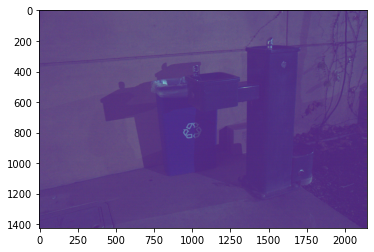

In [ ]:
plt.imshow(img2)
plt.show()

Still some gamma correction is needed (usually) - here it probably doesn't work super well because of the image being mostly dark at the very beggining.

In [ ]:
gcurve = [(i / 255) ** (1 / 2.2) * 255 for i in range(256)]
gcurve = np.array(gcurve, dtype=np.uint8)

img = gcurve[img2]  # apply gamma LUT

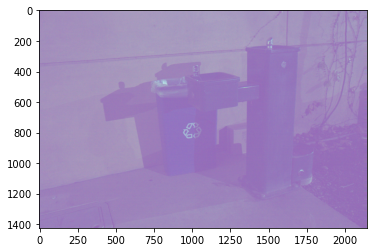

In [ ]:
plt.imshow(img)
plt.show()

Anyway, the image could be somehow processed, obtaining what can be seen as "not that bad" image. Certain paramaters can be relatively easy adjusted to fit the needs for the image to be lighter/darker or to e.g have some color adjusted. \\

We prepared the notebook to provide some "traditional" way of processing image with the most important steps of conerting a RAW image straight from the camera lens to a more humane-lookable one, not to adjust the parameters to fit every image possible - for this we have our neural network setup.



This notebook is based on:
https://www.researchgate.net/publication/314239357_Processing_RAW_images_in_Python

Creating it took waaaaaay too much time.